In [1]:
import os
import tempfile
from functools import partial
import datetime
import wandb
import matplotlib.pyplot as plt
import torch
import pathlib
import numpy as np
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger, WandbLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import sys
sys.path.append("../../")
from data.datasets import WeatherBenchModule
from models import LightningDRN, EmbeddingMLP
import scoringrules as sr
import xarray as xr
import cmcrameri
from uq import GaussianUQMeasure
plt.rcParams['image.cmap'] = 'cmc.vik'
from matplotlib.colors import LogNorm
import scienceplots
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from matplotlib import colormaps as cmp


# Disable gradients
torch.set_grad_enabled(False)

In [2]:
grid = (160,220)
statistics = np.load("/home/groups/ai/datasets/weather_forecasting/era5_statistics.npy")
mean, std = statistics[0]
dm = WeatherBenchModule(train_batch_size=8192, num_workers = 12)
lon, lat = dm.test_dataloader().dataset.get_grid()

In [3]:
ck_path = "../../results/drn/checkpoints/mlp_8.ckpt"
checkpoint = torch.load(ck_path)

/tmp/ipykernel_1585207/2281270681.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ck_path)


In [4]:
mlp = EmbeddingMLP()
model = LightningDRN(mlp)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [5]:
sample = dm.test_dataloader().dataset.__getitem__(10)
input, emb, target = sample
pred = model.predict_step(sample)
input.shape, pred.shape, target.shape

(torch.Size([35200, 5]), torch.Size([35200, 2]), torch.Size([35200, 1]))

In [6]:
mu, sigma = torch.split(pred, 1, -1)
mu = mu.squeeze(-1).reshape(grid).numpy()*std + mean - 273.15
sigma = sigma.squeeze(-1).reshape(grid).numpy()*std
target = target.squeeze().reshape(grid).numpy()* std + mean- 273.15
input = input[...,0].squeeze().reshape(grid).numpy()*std + mean- 273.15

Text(0.5, 1.0, 'Predicted Std Dev')

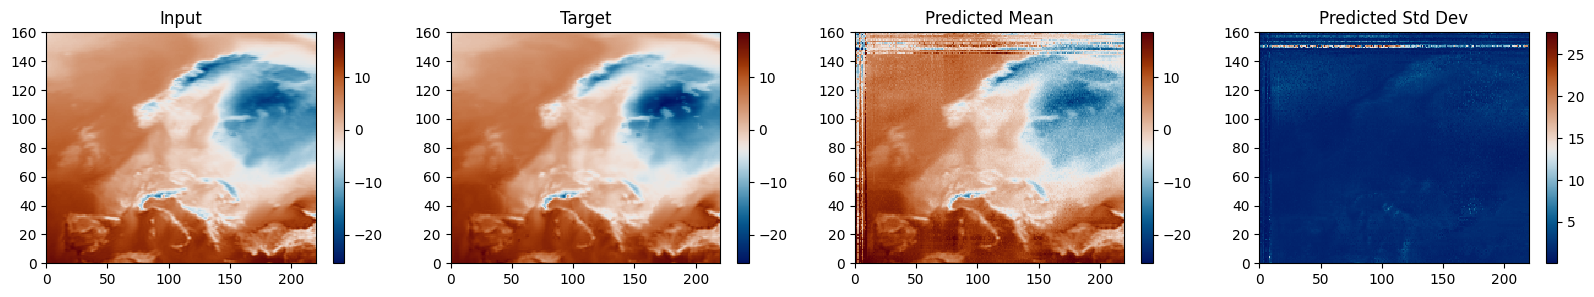

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))
min, max = target.min(), target.max()
im1 = axs[0].pcolormesh(input, vmin=min, vmax=max)
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("Input")

im2 = axs[1].pcolormesh(target, vmin=min, vmax=max)
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("Target")

im3 = axs[2].pcolormesh(mu, vmin=min, vmax=max)
plt.colorbar(im3, ax=axs[2])
axs[2].set_title("Predicted Mean")

im4 = axs[3].pcolormesh(sigma)
plt.colorbar(im4, ax=axs[3])
axs[3].set_title("Predicted Std Dev")


# Plot with iid mask

In [8]:
land_sea_mask = xr.open_zarr("/home/groups/ai/datasets/weather_forecasting/era5.zarr", consolidated=False).land_sea_mask.values
mask = np.where(land_sea_mask > 0.5, 1, 0)
orography = xr.open_zarr("/home/groups/ai/datasets/weather_forecasting/era5.zarr", consolidated=False)["geopotential_at_surface"].values / 9.80665

In [9]:
mu_masked = np.where(mask == 0, np.nan, mu)
sigma_masked = np.where(mask == 0, np.nan, sigma)
input_masked = np.where(mask == 0, np.nan, input)
target_masked = np.where(mask == 0, np.nan, target)

Text(0.5, 1.0, 'Predicted Std Dev')

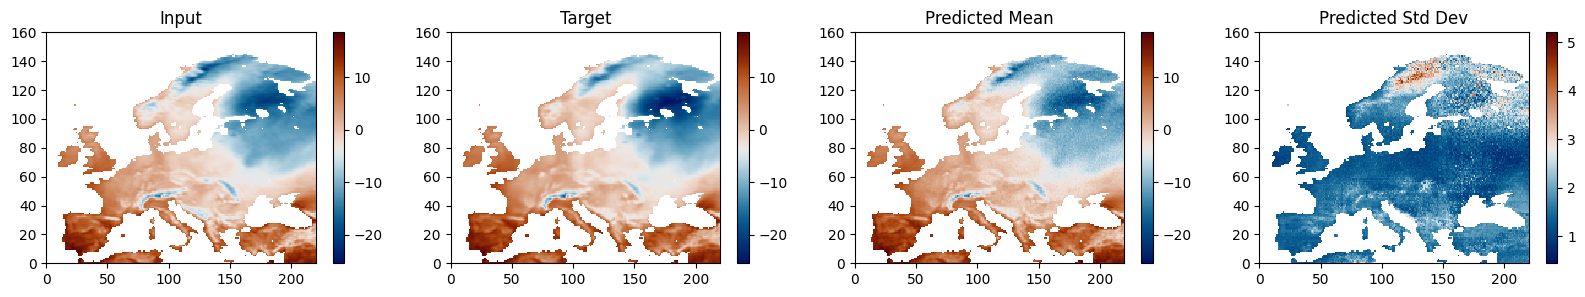

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))
min, max = target.min(), target.max()
im1 = axs[0].pcolormesh(input_masked, vmin=min, vmax=max)
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("Input")

im2 = axs[1].pcolormesh(target_masked, vmin=min, vmax=max)
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("Target")

im3 = axs[2].pcolormesh(mu_masked, vmin=min, vmax=max)
plt.colorbar(im3, ax=axs[2])
axs[2].set_title("Predicted Mean")

im4 = axs[3].pcolormesh(sigma_masked)
plt.colorbar(im4, ax=axs[3])
axs[3].set_title("Predicted Std Dev")

# Plot with OOD mask

In [11]:
mu_masked = np.where(mask == 1, np.nan, mu)
sigma_masked = np.where(mask == 1, np.nan, sigma)
input_masked = np.where(mask == 1, np.nan, input)
target_masked = np.where(mask == 1, np.nan, target)

Text(0.5, 1.0, 'Predicted Std Dev')

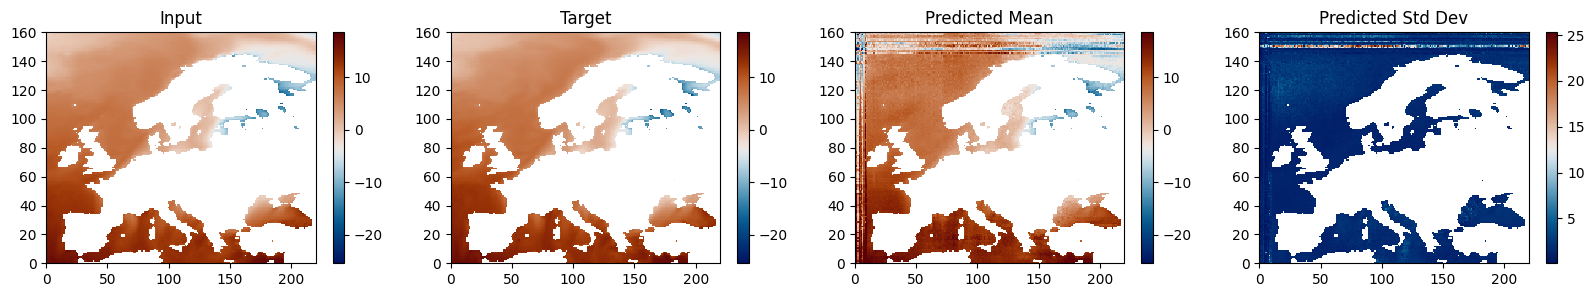

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3))
min, max = target.min(), target.max()
im1 = axs[0].pcolormesh(input_masked, vmin=min, vmax=max)
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("Input")

im2 = axs[1].pcolormesh(target_masked, vmin=min, vmax=max)
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("Target")

im3 = axs[2].pcolormesh(mu_masked, vmin=min, vmax=max)
plt.colorbar(im3, ax=axs[2])
axs[2].set_title("Predicted Mean")

im4 = axs[3].pcolormesh(sigma_masked)
plt.colorbar(im4, ax=axs[3])
axs[3].set_title("Predicted Std Dev")

# Kernel choice

In [25]:
def median_heuristic_gamma(x: torch.Tensor) -> torch.Tensor:
    """
    Computes the gamma parameter for a Gaussian kernel using the median heuristic.
    
    Args:
        x (torch.Tensor): Input tensor of shape (B, M) where B is batch size and 
                          M are samples from a 1D standardized distribution.
                          
    Returns:
        torch.Tensor: Gamma values of shape (B,), one per batch.
    """
    B, M = x.shape
    
    # Expand dimensions for pairwise distance computation
    x1 = x.unsqueeze(2)  # (B, M, 1)
    x2 = x.unsqueeze(1)  # (B, 1, M)
    
    # Compute pairwise squared distances
    dists = (x1 - x2) ** 2  # (B, M, M)
    
    # Flatten upper triangular part (excluding diagonal)
    triu_indices = torch.triu_indices(M, M, offset=1)
    dists_flat = dists[:, triu_indices[0], triu_indices[1]]  # (B, M*(M-1)/2)
    
    # Median over pairwise distances
    median_sq = dists_flat.median()  # (B,)
    
    # Gamma is sqrt of median squared distance
    gamma = torch.sqrt(median_sq)
    return gamma



In [29]:
mu = results[0:5,:,:,0,0]
sigma = results[0:5,:,:,1,0]
sample_pred = torch.distributions.normal.Normal(torch.tensor(mu), torch.tensor(sigma)).rsample().reshape(10,-1)
sample_pred.shape

torch.Size([10, 17600])

In [23]:
results.shape

(365, 160, 220, 2, 10)

In [30]:
# Example usage:
median_heuristic_gamma(sample_pred)

tensor(6.5601, dtype=torch.float64)

# Analyze uncertainties

In [10]:
mlp = EmbeddingMLP()
model = LightningDRN(mlp)
sample = dm.test_dataloader().dataset.__getitem__(10)
input, emb, target = sample

batch_size = 365

target = target.squeeze().reshape(grid).numpy()* std + mean- 273.15
input = input[...,0].squeeze().reshape(grid).numpy()*std + mean- 273.15

In [11]:
len(dm.test_dataloader().dataset)

365

In [12]:
checkpoints = [1,2,3,4,5,6,7,8,9,10]
results = np.zeros((batch_size, 160,220, 2, len(checkpoints)))
for i,c in enumerate(checkpoints):
    ck_path = f"../../results/drn/checkpoints/mlp_{c}.ckpt"
    checkpoint = torch.load(ck_path)
    model.load_state_dict(checkpoint["state_dict"])

    for s,sample in enumerate(dm.test_dataloader()):
        input, emb, target = sample    
        pred = model.predict_step(sample).reshape(160,220,2)
        pred[...,0] = pred[...,0]*std + mean - 273.15
        pred[...,1] = pred[...,1]*std  
        
        results[s,...,i] = pred

/tmp/ipykernel_1585207/4253467555.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ck_path)


# Plot results

In [13]:
measures = ["log", "var", "crps", "kernel"]
names = [r"$S_\mathrm{log}$",r"$S_\mathrm{SE}$",r"$S_\mathrm{ES}$",r"$S_{k_\gamma}$"]

In [14]:
plt.style.use('science')
titlesize = 32
labelsize = 24
ticksize = 20
axissize = 27

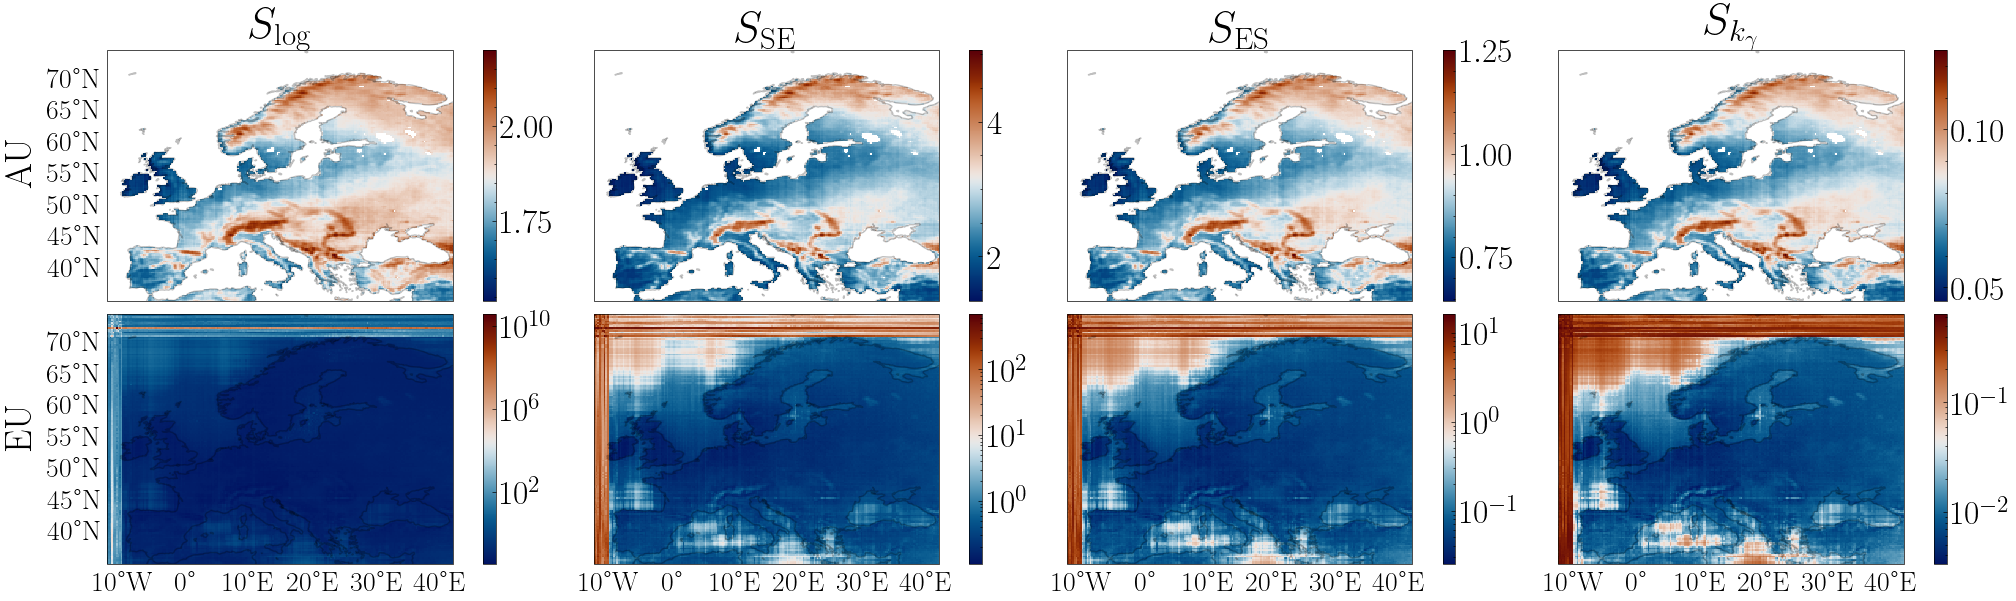

In [17]:
fig, axs = plt.subplots(2, len(measures), figsize=(20, 6), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
for s,measure in enumerate(measures):
    uq_measure = GaussianUQMeasure(torch.tensor(results), gamma = 5)
    au, eu, _ = uq_measure.get_uncertainties(measure = measure)
    au = au.mean(dim = 0)
    eu = eu.mean(dim = 0)
    au = np.where(land_sea_mask <= 0.5, np.nan, au)

    # Plot
    im1 = axs[0,s].pcolormesh(lon, lat, au, shading = "nearest", rasterized = True)
    cb = plt.colorbar(im1, ax=axs[0,s])
    cb.ax.tick_params(labelsize = labelsize)

    im2 = axs[1,s].pcolormesh(lon, lat, eu,rasterized = True, norm = LogNorm())
    cb2 = plt.colorbar(im2, ax=axs[1,s])
    cb2.ax.tick_params(labelsize = labelsize)

    axs[0,s].set_title(names[s], fontsize = titlesize)

for ax in axs.ravel():
    ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, alpha = 0.25)

for i in range(4):
    gl = axs[1,i].gridlines(draw_labels={"bottom":"x"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size':ticksize}

for i in range(2):
    gl = axs[i,0].gridlines(draw_labels={"left":"y"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.ylabel_style = {'size':ticksize}

axs[0,0].text(-0.2, 0.55, 'AU', va='bottom', ha='center',
              rotation='vertical', rotation_mode='anchor',
              transform=axs[0,0].transAxes, fontsize = axissize)
axs[1,0].text(-0.2, 0.55, 'EU', va='bottom', ha='center',
     rotation='vertical', rotation_mode='anchor',
    transform=axs[1,0].transAxes, fontsize = axissize)

plt.savefig("../../plots/drn_uncertainty.pdf", bbox_inches = "tight")

# Data Characteristics

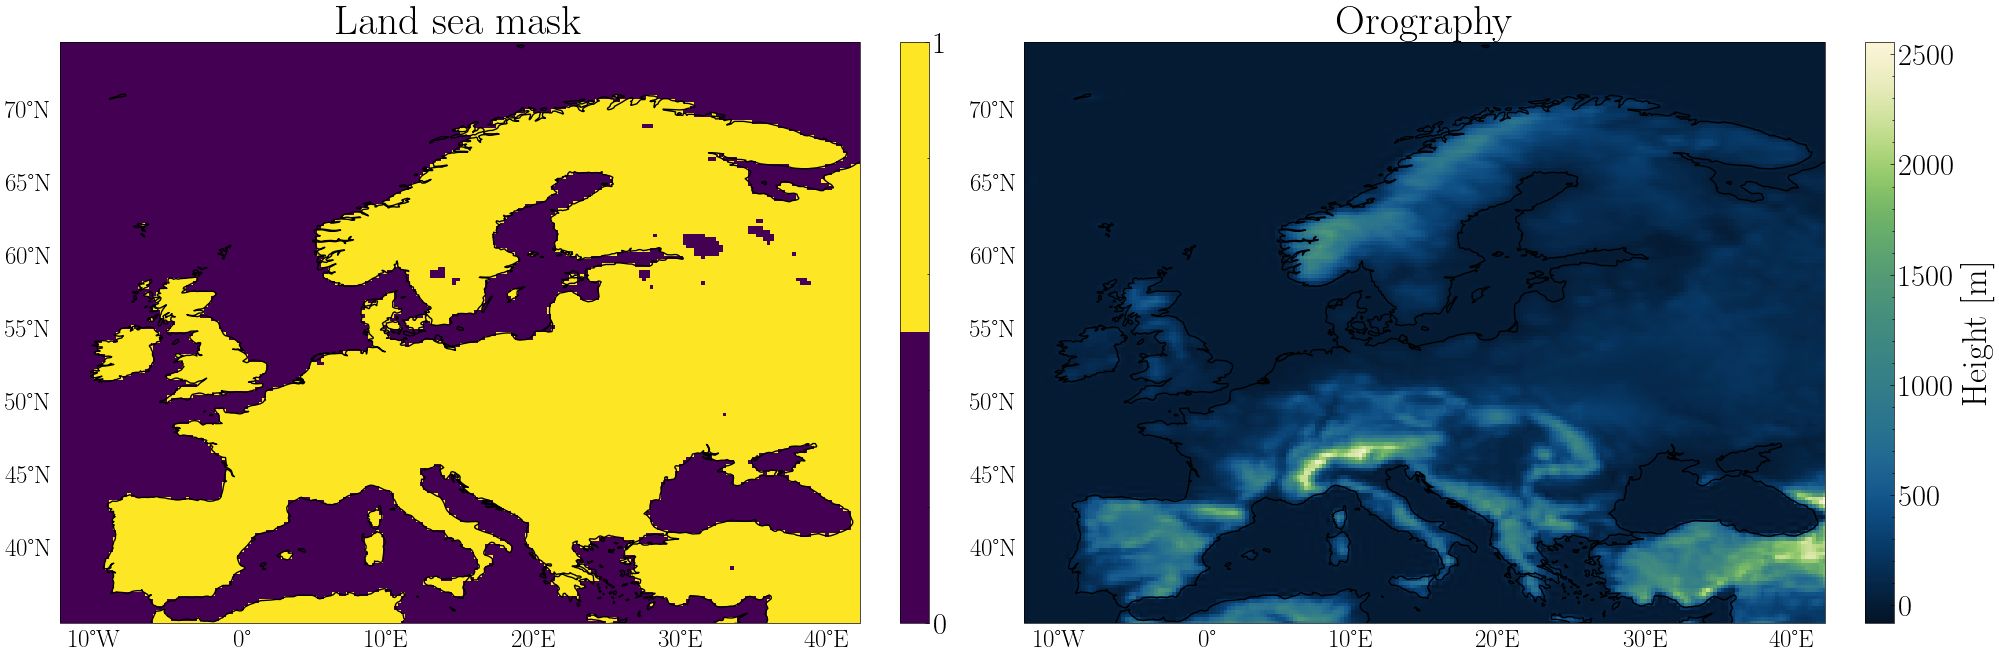

In [21]:
# Discrete colorbar
viridis = cmp.get_cmap('viridis')    
col_dict = {0: viridis(0),
            1: viridis(0.999)}

# We create a colormar from our list of colors
cmap_coverage = ListedColormap([col_dict[x] for x in col_dict.keys()])

fig, axs = plt.subplots(1, 2, figsize=(20, 7), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
im1 = axs[0].pcolormesh(lon, lat, mask, shading = "nearest", cmap = cmap_coverage, rasterized = True)
cb = plt.colorbar(im1, ax=axs[0], label = "", ticks = np.array([0,1]), shrink = 0.84)
cb.ax.tick_params(labelsize = labelsize)
axs[0].set_title("Land sea mask", size = titlesize)

im2 = axs[1].pcolormesh(lon , lat, orography, shading = "nearest", cmap = "cmc.navia", rasterized = True)
cb2 = plt.colorbar(im2, ax=axs[1], shrink = 0.84)
cb2.set_label('Height [m]',size=axissize)
cb2.ax.tick_params(labelsize = labelsize)
axs[1].set_title("Orography", size = titlesize)

for ax in axs.ravel():
    ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels={"bottom":"x", "left":"y"}, dms=True, x_inline=False, y_inline=False)
    gl.ylabel_style = {'size':ticksize}
    gl.xlabel_style = {"size":ticksize}
    gl.xlines = False
    gl.ylines = False

plt.savefig("../../plots/drn_data.pdf", bbox_inches = "tight")

# Relative deviation of OOD EU against mean ID EU

Text(-0.2, 0.55, 'EU')

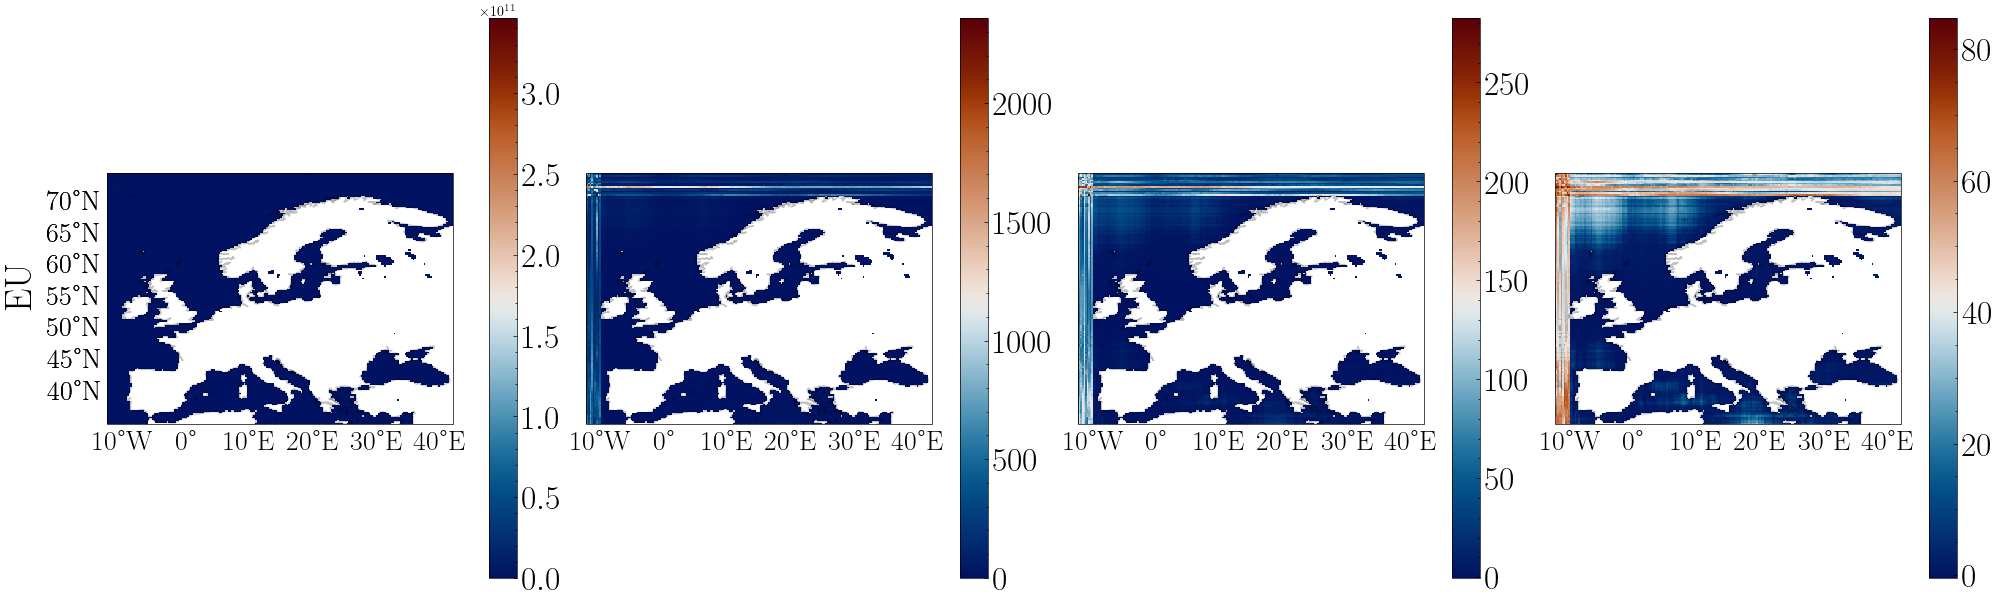

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(20, 3), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
axs = axs.ravel()
for s,measure in enumerate(measures):
    uq_measure = GaussianUQMeasure(torch.tensor(results), gamma = 5)
    au, eu, _ = uq_measure.get_uncertainties(measure = measure)
    eu = eu.mean(dim = 0)
    eu_in = np.where(land_sea_mask <= 0.5, np.nan, eu).flatten()
    eu_in = eu_in[~np.isnan(eu_in)].mean()
    eu_out = np.where(land_sea_mask> 0.5, np.nan, eu)
    eu_change = (eu_out - eu_in)/eu_in


    # Plot
    im1 = axs[s].pcolormesh(lon, lat, eu_change, shading = "nearest", rasterized = True)
    cb = plt.colorbar(im1, ax=axs[s])
    cb.ax.tick_params(labelsize = labelsize)

for ax in axs:
    ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, alpha = 0.25)

for i in range(4):
    gl = axs[i].gridlines(draw_labels={"bottom":"x"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size':ticksize}

for i in range(2):
    gl = axs[0].gridlines(draw_labels={"left":"y"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.ylabel_style = {'size':ticksize}

axs[0].text(-0.2, 0.55, 'EU', va='bottom', ha='center',
     rotation='vertical', rotation_mode='anchor',
    transform=axs[0].transAxes, fontsize = axissize)

# Table

In [44]:
for s,measure in enumerate(measures):
    uq_measure = GaussianUQMeasure(torch.tensor(results), gamma = 5)
    __annotations__, eu, _ = uq_measure.get_uncertainties(measure = measure)
    eu = eu.mean(dim = 0)
    eu_in = np.where(land_sea_mask <= 0.5, np.nan, eu).flatten()
    eu_in = eu_in[~np.isnan(eu_in)]
    eu_out = np.where(land_sea_mask> 0.5, np.nan, eu).flatten()
    eu_out = eu_out[~np.isnan(eu_out)]

    print(measure)
    print(f"EU-in: {eu_in.mean()}")
    print(f"EU-out: {eu_out.mean()}")

log
EU-in: 0.09202997995006859
EU-out: 29390240.14568594
var
EU-in: 0.3013018857009926
EU-out: 20.342305658042118
crps
EU-in: 0.05814463408172306
EU-out: 1.325681197861663
kernel
EU-in: 0.007559514501035041
EU-out: 0.11771054517994615


In [43]:
eu_in.shape, eu_out.shape

((17739,), (17461,))